# NV Center in Diamond
An example of computing Hahn-echo coherence function using all three available methods: 

- Conventional CCE
- Generalized CCE (gCCE)
- gCCE with Monte-Carlo bath sampling

And the examples of converging the calculational parameters

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Install a pip package in the current Jupyter kernel
import sys
sys.path.append('/home/onizhuk/midway/codes_development/pyCCE')
import pycce as pc
# !{sys.executable} -m pip install --user ase
# !{sys.executable} -m pip install --user numpy --upgrade

import ase

seed = 8805
np.random.seed(seed)
np.set_printoptions(suppress=True, precision=5)

## Generate nuclear spin bath
Building a supercell of nuclear spins from the `ase.Atoms` object.

### Build BathCell

To do it from `ase.atoms` object, use classmethod `BathCell.from_ase`

In [2]:
from ase.build import bulk

# Generate unitcell from ase
diamond = bulk('C', 'diamond', cubic=True)
diamond = pc.bath.BathCell.from_ase(diamond)

The following attributes created with this initiallization:
 - `.cell` is ndarray containing information of lattice vectors. Each **column** is a lattice vector in the cartesian coordinates
 - `.atoms` is a dictionary with keys corresponding to the atom name, and each item is a list of the coordinates in cell coordinates

In [3]:
print('Cell\n', diamond.cell)
print('\nAtoms\n', diamond.atoms)

Cell
 [[3.57 0.   0.  ]
 [0.   3.57 0.  ]
 [0.   0.   3.57]]

Atoms
 {'C': [array([0., 0., 0.]), array([0.25, 0.25, 0.25]), array([0. , 0.5, 0.5]), array([0.25, 0.75, 0.75]), array([0.5, 0. , 0.5]), array([0.75, 0.25, 0.75]), array([0.5, 0.5, 0. ]), array([0.75, 0.75, 0.25])]}


### Populate BathCell with isotopes

Use function `BathCell.add_isotopes` to add one (or several) isotopes of the element with tuples containing name of the isotope and it's concentration. 
Name of the isotope includes number and element symbol, provided in the `atoms` object. Returns dictionary `BathCell.isotopes` which can be modified directly. Structure of the dictionary:

```
{element_1: {isotope_1: concentration, isotope_2: concentration},
 element_2: {isotope_3: concentration ...}}
```


In [4]:
# Add types of isotopes
diamond.add_isotopes(('13C', 0.011))

{'C': {'13C': 0.011}}

The direct addition of the isotopes to the `BathCell.isotopes` can also be done. Here we are adding a dummy isotope without the nuclear spin:

In [6]:
diamond.isotopes['C']['14C'] = 0.001

### Set z-direction of the bath (optional)

In the `Simulator` object everything is set in $S_z$ basis. When quantization axis of the defect does not allign with (0,0,1) direction of the crystal axis, the user has to set it themselves

In [7]:
# set z direction of the defect
diamond.zdir = [1, 1, 1]

### Generate spin bath

To generate spin bath, use `BathCell.gen_supercell` function. First argument is the approx. linear size of the supercell. Additional keyword arguments `remove` and `add`.

`remove` takes a tuple or list of tuples of the atomic positions to remove in the final supercell (if applicable). First element of the tuple is the name of the **atom** at that location, second element - coordinates in unit cell coordinates.

`add` takes a tuple or list of tuples of the isotopes to add in the final supercell. First element of the tuple is the name of the **isotope** at that location, second element - coordinates in unit cell coordinates.

In [8]:
# Add the defect. remove and add atoms at the positions (in cell coordinates) 
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                           ('C', [0.5, 0.5, 0.5])],
                              add=('14N', [0.5, 0.5, 0.5]),
                              seed=seed)

/home/onizhuk/midway/codes_development/pyCCE/pycce/bath/array.py:190: UserWarning: Spin type for 14C was not provided and was not found in common isotopes.
  warnings.warn(


Note, that because `14C` isotope doesn't have nuclear spin, pyCCE does not find it in common isotopes, and raises a warning. We have to provide `SpinType` for it separately.

## BathArray Structure
The bath spins are stored in `BathArray` object - a subclass of `np.ndarray` with fixed datastructure:
- `N` field `dtype('<U16')` contains the names of bath spins
- `xyz` field `dtype('<f8', (3,))` contains the positions of bath spins (in A)
- `A` field `dtype('<f8', (3, 3))` contains the hyperfine coupling of bath spins (in rad*kHz)
- `Q` field `dtype('<f8', (3, 3))` contains the quadrupole tensor of bath spins (in rad*kHz)

All of the fields are accesible as attributes of `BathArray`.

The properties of spin types (e.g. gyro, quadrupole moment, etc) are stored in `BathArray.types` attribute, which is instance of `SpinDict` containing `SpinType` classes. For most known isotopes `SpinType` is set by default (including electron spin-1/2, which is denoted by setting `N = e`). User can add additional `SpinType`s objects, by calling `BathArray.add_type` method, or setting elements of `SpinDict` directly. For details of first approach see help for `SpinDict.add_type` method.

The direct setting of types is rather simple. User can set elements of `SpinDict` with tupple, containing: `(spin, gyromagnetic ratio, quadrupole moment)` **OR** `(isotope, gyromagnetic ratio, quadrupole moment)`  where `isotope` is the name of the `spin` (same one as in `N` field of `BathArray`) to define new `SpinType` object. The key of `SpinDict` **has** to be the correct name of the spin (`isotope` field in the tuple). Units of gyromagnetic ratio are kHz * rad, Q are given in barn.

In [9]:
# Several ways to set SpinDict elements
atoms.types['14C'] = 0, 0, 0
atoms.types['Y'] = ('Y', 0, 0, 0)
atoms.types['A'] = pc.SpinType('A', 0, 0, 0)

print(atoms.types)

SpinDict({'13C': (13C, 0.5, 6.7283, 0), '14N': (14N, 1, 1.9338, 0.02044), '14C': (14C, 0, 0, 0), 'Y': (Y, 0, 0, 0), 'A': (A, 0, 0, 0)})


## CCE Simulator
Setting the parameters of CCE simulator engine.

Main parameters to consider:
- `alpha` — first qubit state in $S_z$ basis
- `beta` — second qubit state in $S_z$ basis
- `position` — coordinates of the central spin
- `order` — maximum size of the cluster
- `r_bath` — cutoff radius around the central spin for the bath
- `r_dipole` — cutoff radius for the pairwise distance to consider two nuclear spins to be connected

Additional parameters, necessary for generalized CCE and gCCE
- `D` ZFS Tensor of central spin, or axial ZFS
- `E` if D is not a tensor, then transverse ZFS

In [10]:
# Parameters of CCE calculations engine

# Order of CCE aproximation
order = 2
# Bath cutoff radius
r_bath = 40  # in A
# Cluster cutoff radius
r_dipole = 8  # in A
# position of central spin
position = [0, 0, 0]
# Qubit levels (in Sz basis)
alpha = [0, 0, 1]; beta = [0, 1, 0]
# ZFS Parametters of NV center in diamond
D = 2.88 * 1e6 * 2 * np.pi # in kHz * rad
E = 0 # in kHz * rad
zfs = pc.zfs_tensor(D, E)

The code already knows the most isotopes, however user can provide their own. The way to initiallize `SpinType` objects is the same as in for `SpinDict` above.

In [10]:
# The code already knows most exsiting isotopes.
#              Bath spin types
#              name    spin    gyro       quadrupole moment (for s>1/2)
spin_types = [('14N',  1,      1.9338,    20.44),
              ('13C',  1 / 2,  6.72828),
              ('29Si', 1 / 2, -5.3188),]

### Setting the `Simulator` object
All of the kwargs can be provided at the moment of creation. If all of the kwargs are provided, several methods of `Simulator` class are called:
- `Simulator.read_bath`
- `Simulator.generate_clusters`

The details are available in the `Simulator` methods description

In [11]:
# Setting the runner engine
calc = pc.Simulator(spin=1, position=position, alpha=alpha, beta=beta,
                    types=spin_types, D=D, E=E,
                    bath=atoms, r_bath=r_bath,
                    r_dipole=r_dipole, order=order)

Taking advantage of subclassing `np.ndarray` we can change *in situ* the quadrupole tensor of Nitrogen nuclear spin

In [12]:
nspin = calc.bath
# Set model quadrupole tensor at N atom
nspin['Q'][nspin['N'] == '14N'] = np.asarray([[-2.5, 0, 0],
                                              [0, -2.5, 0],
                                              [0, 0,  5.0]]) * 1e3 * 2 * np.pi

### Compute coherence function with conventional CCE

In conventional CCE method the Hamiltonian is projected on the qubit levels, and the coherence is computed from the overlap of evolution of the bath, entangled with two different qubit states.

The conventional CCE requires several arguments:
- `timespace` — time points at which compute the coherence function
- `N` — number of pulses in CPMG sequence (0 - FID, 1 - HE etc.)
- `B` — array of the magnetic field

For details see `help(calc.cce_coherence)`

In [13]:
# Time points
time_space = np.linspace(0, 2, 201)  # in ms
# Number of pulses in CPMG seq (0 = FID, 1 = HE)
N = 1
# Mag. Field (Bx By Bz)
B = np.array([0, 0, 500])  # in G

l_conv = calc.compute(time_space, B, N, method='cce', quantity='coherence', as_delay=False)

In [14]:
%timeit calc.compute(time_space, B, N, method='cce', quantity='coherence', as_delay=False)

1.41 s ± 4.96 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Generalized CCE (gCCE)

In contrast, in generalized CCE each cluster includes the central spin explicitly.

Generalized CCE can take `pulse_sequence` agrument instead of N:
- `pulse_sequence` actual pulse sequence can be provided as a list of tuples. In each tuple first entry axis, second entry - rotational angle. Otherwise `N` argument is also accepted

For details see `help(calc.generalized_cce_dm)`

In [15]:
# Hahn-echo pulse sequence
pulse_sequence = [('x', np.pi)]

# Calculate coherence function
l_generatilze = calc.compute(time_space, B, pulse_sequence=pulse_sequence, mean_field=False,
                             method='gcce', quantity='coherence')

/home/onizhuk/anaconda3/lib/python3.8/site-packages/numpy/ma/core.py:473: ComplexWarning: Casting complex values to real discards the imaginary part
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


In [16]:
%timeit calc.compute(time_space, B, pulse_sequence=pulse_sequence, D=D, E=E, method='gcce', mean_field=False, quantity='coherence')

4.07 s ± 30.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### gCCE with random sampling of bath states
This approach conducts generalized CCE calculations for set of random bath states. Can be turn on by by setting keyword argument `mean_field` to `True`. Compared to generalized CCE, requires one additional argument `nbstates`. Recommended number of bath states is above 100, but the convergence should be checked for each system. Note, that this computation is roughly `nbstates` times longer than generalized CCE, as it computes everything `nbstates` times.

For details see `help(calc.gcce_dm)`

In [20]:
# Number of random bath states to sample over
n_bath_states = 30

# Calculate coherence function
l_gcce = calc.compute(time_space, B, pulse_sequence=pulse_sequence, mean_field=True,
                      nbstates=n_bath_states, method='gcce', quantity='coherence', seed=seed)

/home/onizhuk/anaconda3/lib/python3.8/site-packages/numpy/ma/core.py:473: ComplexWarning: Casting complex values to real discards the imaginary part
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


In [18]:
n_bath_states = 10
%timeit calc.compute(time_space, B, pulse_sequence=pulse_sequence, nbstates=n_bath_states, method='gcce', quantity='coherence', seed=seed)

46.2 s ± 809 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


look at all and check that they produce similar results. Note gCCE deviates from other results as number of states is not enough to converge

Text(0, 0.5, 'L')

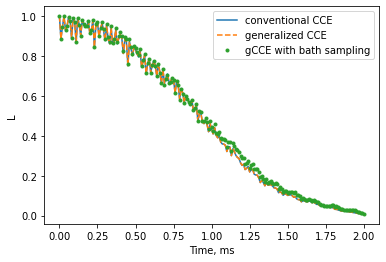

In [21]:
plt.plot(time_space, l_conv.real, label='conventional CCE')
plt.plot(time_space, l_generatilze.real, label='generalized CCE', ls='--')
plt.plot(time_space, l_gcce.real, label='gCCE with bath sampling', ls='', marker='.')

plt.legend()
plt.xlabel('Time, ms')
plt.ylabel('L')

### Convergence parameters
Having confirmed that all methods produce the same results, we check convergence of conventional CCE with respect to `order`, `r_bath`, `r_dipole` parameters of the `Simulator` object.

First, define all of the parameters.

In [32]:
parameters = dict(
    order=2, # CCE order
    r_bath=40,  # Size of the bath in A
    r_dipole=8,  # Cutoff of pairwise clusters in A
    position=[0, 0, 0], # Position of central Spin
    alpha=[0, 0, 1],
    beta=[0, 1, 0]
) # Qubit levels)

time_space = np.linspace(0, 2, 201)  # Time points in ms
N = 1 # N pulses in CPMG sequence
B = np.array([0, 0, 500])  # Magnetic field in G

We can define a little helper function to streamline the process:

In [33]:
def runner(variable, values):
    invalue = parameters[variable]
    ls = []

    for v in values:
        parameters[variable] = v
        calc = pc.Simulator(spin=1, bath=atoms, **parameters)
        l = calc.compute(time_space, B, N, method='cce', quantity='coherence', as_delay=False)
        ls.append(l.real)

    parameters[variable] = invalue
    ls = pd.DataFrame(ls, columns=time_space, index=values).T
    return ls

Now we can compute the coherence function at different values of the parameters:

In [34]:
orders = runner('order', [1, 2, 3, 4])

In [35]:
rbs = runner('r_bath', [20, 30, 40, 50, 60])

In [36]:
rds = runner('r_dipole', [4, 6, 8, 10])

We can visualize the convergence of coherence function with respect to different parameters:

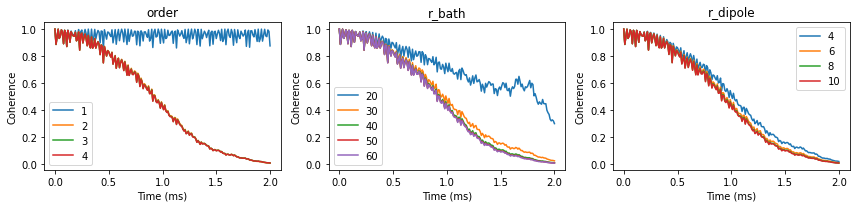

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
orders.plot(ax=axes[0], title='order')
rbs.plot(ax=axes[1], title='r_bath')
rds.plot(ax=axes[2], title='r_dipole')
for ax in axes:
    ax.set(xlabel='Time (ms)', ylabel='Coherence')
fig.tight_layout()